<a href="https://colab.research.google.com/github/chaehyun99/semantic_segmentation_labeling_tool/blob/main/PBL_NetModel_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#-본 문서는[ PBL_NetModel2](https://colab.research.google.com/drive/1S-oUYcKj25EnEpiJxtVad0LZBAaudJZU#scrollTo=V5jc1MQRCDig) 노트북에서 당장에 필요없는 부분들을 제외하고

# 최소로 필요하고 제대로 작동하는 셀만 모은 코드입니다-

#작업상황 및 달성목표 기록

1(done):  https://github.com/kairess/torchvision_walkthrough/blob/master/segmentation.ipynb 
어느정도 튜토리얼의 흐름을 따라가되 사용하는 모듈이나 요구사항에 안맞는 부분들 수정 및 개선하는 방식으로 작업예정.

2(todo): class map? segmap?의 표시할 객체 목록 바꾸기.

3(done): GPU 존재시 텐서와 모델을 CUDA로 옮기는 조건문.

4(almost done): 이미지 입출력 로컬경로에서 부르도록 바꾸기.

        !아직 PIL에서의 입출력과 opencv에서의 입출력을 중구난방으로 쓰고있음
        한번 쭉 정리해서 통일하거나 필요한 부분만 사용

        Image.open()과 cv2.imread()는 결과값이 다른형태로 나옴.

5(todo): 코드를 두개의 클래스로 분리

       1. class.모델구동의 출력물 저장. 2. class.팔레트 이미지 생성 

       -시간상 다음 주차로 넘김.
       
       -어느 정도 프로그램의 플로우가 머리에 있긴 하지만 뒤늦게
       인터페이스가 안맞다거나 해서 주먹구구로 수정하지 않으려면 
       세밀한 서류까진 아니더라도 한번 작성해봐야할듯함.


6(todo): 코드에서 모델호출부분만 다른 모델로 바꿔보며 테스트. (데이터셋 주의)

7(half done): 이미지 저장 포맷을 입력 포맷과 맞추기

      1. 출력할 객체가 텐서,배열(보통배열인지, dim=0인지)인지 확인해서 변환

      2. 확장자만 문자열로 분리해서 넘겨주는 방법 어떤지.(입출력용 클래스 선언?)

8(done): 작업진행할 내용 단위로 노트북 상에서 코드 블록 분리 (런타임 구분겸)


9(todo,trying): PIL.Image를 사용한 사진 입,출력 및 팔레트 이미지 생성 구문 CV2의 메소드로 전부 대체

      OpenCV위주로 작성했을때 장점?) numpy array를 사용하기 좋고,
       C#에서 불러쓰거나 필요하다면 코드 호환시키기도 좋아보임.
      (C#에서 바로 만들수 있는 클래스는 굳이 python에서 불러올 이유가 없다.

      참고:   https://chacha95.github.io/2019-08-01-PIL-vs-OpenCV/
      위 글에 따르면 torchvision.trasforms의 메소드들이 PIL image array위주라  하는데 
      cv2.imread()로 읽어온 ndarray에 해당 메소드 적용했을때 문제되는지 확인해봐야 함.

In [ ]:
#source: https://github.com/kairess/torchvision_walkthrough/blob/master/segmentation.ipynb
'''
brew install libomp (for OSX)
pip install torchtext -U
'''
import torch
import torchvision
from torchvision import models
import torchvision.transforms as T

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import cv2 as cv 

print('pytorch', torch.__version__)
print('torchvision', torchvision.__version__)



pytorch 1.7.0+cu101
torchvision 0.8.1+cu101


In [ ]:

#2(todo)
COLORS = np.array([
    (0, 0, 0),       # 0=background
    (128, 0, 0),     # 1=aeroplane
    (0, 128, 0),     # 2=bicycle
    (128, 128, 0),   # 3=bird
    (0, 0, 128),     # 4=boat
    (128, 0, 128),   # 5=bottle
    (0, 128, 128),   # 6=bus
    (128, 128, 128), # 7=car
    (255, 255, 255), # 8=cat
    (192, 0, 0),     # 9=chair
    (64, 128, 0),    # 10=cow
    (192, 128, 0),   # 11=dining table
    (64, 0, 128),    # 12=dog
    (192, 0, 128),   # 13=horse
    (64, 128, 128),  # 14=motorbike
    (192, 128, 128), # 15=person
    (0, 64, 0),      # 16=potted plant
    (128, 64, 0),    # 17=sheep
    (0, 192, 0),     # 18=sofa
    (128, 192, 0),   # 19=train
    (0, 64, 128)     # 20=tv/monitor    

])
#표시할 레이블을 20개 이상 잡을 필요는 없을듯(구분 힘듬,가시성 x)

#6(todo) Download Model

deeplab = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()



In [ ]:

#4(todo) Load Image

##From here: Web에서 이미지를 받아서 저장하고 filename을 상속.
import urllib.request
import urllib
url, filename = ("https://i2.wp.com/sanantonioreport.org/wp-content/uploads/2018/09/bonnie_arbittier_bonniearbittier_dockless_scooter_escooter_scooters_bike_bikes_public_hearing_city_council_9-12-2018-10.jpg?fit=1170%2C780&ssl=1", "bikes.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

print('-load image from Web-')
##To here: 로컬경로에서 불러오는 코드로 대체 예정.


img = Image.open(filename) #문자열(경로,파일이름?)을 파라미터로 받아 해당 지점에서 파일 읽어들임. 없으면 해당 이름으로 생성하여 실행.

type(img)

-load image from Web-


PIL.JpegImagePlugin.JpegImageFile

image save complete
-load image from Local_path-


PIL.JpegImagePlugin.JpegImageFile

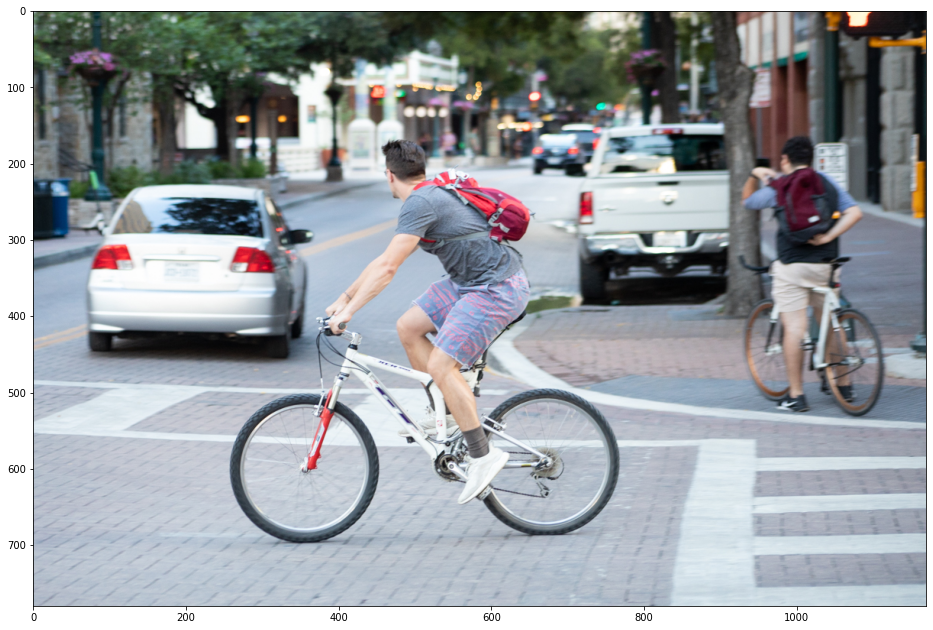

In [ ]:


##From here 4(todo)
img.save("img_test_saving.jpg",'JPEG') #for test
print('image save complete')

filename = Image.open("img_test_saving.jpg")# <____--_______________-여기에 이미지 불러올 경로 인가하면 됨. 
                                          #경로(문자열 객체)를 파라미터로 받아서 주면 될것
print('-load image from Local_path-')
##To here 4(todo):  로컬경로에서 이미지를 open해서 filename에 상속(?).


plt.figure(figsize=(16, 16)) # matplotlib에서 보여줄 때의 사이즈 지정.
plt.imshow(img)

type(filename)

In [ ]:

#Image to Tensor(preprocess) 
#원 코드에서 이미지를 resizing하는 부분 있었는데 삭제함. (출력할때 원본 이미지의 사이즈에서 바뀌지 않아야 함.)

trf = T.Compose([
    T.ToTensor(), 
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
#trf에 이미지를 변환하는 T.Compose(실 내용은 ToTensor와 Normalize) 메소드. 
#변환할 내용은 PIL이미지(현재)나 numpy.ndarray를(실제론 확인 못해봄) 텐서로 바꾸고, 정교화하는 코드.

#torchvision.transforms.transform.compse([])에서 []안에 각종 transform 메소드를 나열하면 한번에 작성가능.
"""
torchvision.transforms.ToTensor

Convert a PIL Image or numpy.ndarray to tensor. This transform does not support torchscript.
PIL Image가 아니고 numpy.ndarray여도 텐서로 변환할수 있는 메소드인것 확인. 

Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has dtype = np.uint8

In the other cases, tensors are returned without scaling.
"""

"""
torchvision.transforms.Normalize(mean, std, inplace=False)[SOURCE]
Normalize a tensor image with mean and standard deviation. Given mean: (mean[1],...,mean[n]) and std: (std[1],..,std[n]) for n channels, this transform will normalize each channel of the input torch.*Tensor i.e., output[channel] = (input[channel] - mean[channel]) / std[channel]
"""

print(trf(img).shape)

torch.Size([3, 780, 1170])


In [ ]:
input_img = trf(img).unsqueeze(0)
 #trf(img)는 img를 텐서로 변환하고 정규화까지 거친 상태의 torch.tensor이며 torch.unsqueeze()는 해당 텐서에 차원 크기를 1 추가해준다.

print(input_img.shape)


torch.Size([1, 3, 780, 1170])


In [ ]:


 #결과적으로 deeplab()에 파라미터로 주어질 input_img는 torch.tensor고 shape는 torch.Size([1, 3, 780, 1170])로 출력됨.


#(done)3  move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_img = input_img.to('cuda')
    deeplab.to('cuda')

#Inference


out = deeplab(input_img)['out']

print(out.shape)



torch.Size([1, 21, 780, 1170])


In [ ]:
#Extract Class Map

out = torch.argmax(out.squeeze(), dim=0) #여기까진  out이 torch.tensor임
out = out.detach().cpu().numpy()        #이 구문 실행후 out은 numpy.ndarray임.
                                      #근데 왜 fromarray()가 안될까
print(out.shape)
print(np.unique(out))


(780, 1170)
[ 0  2  7 15]


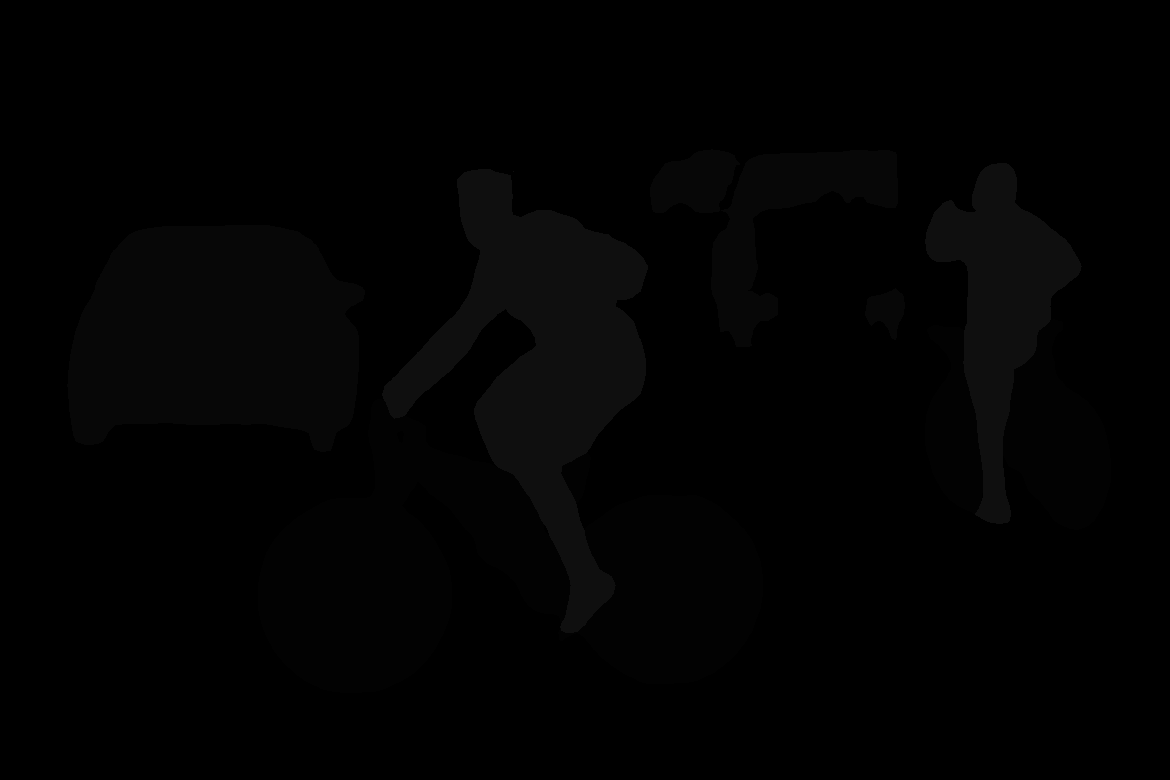

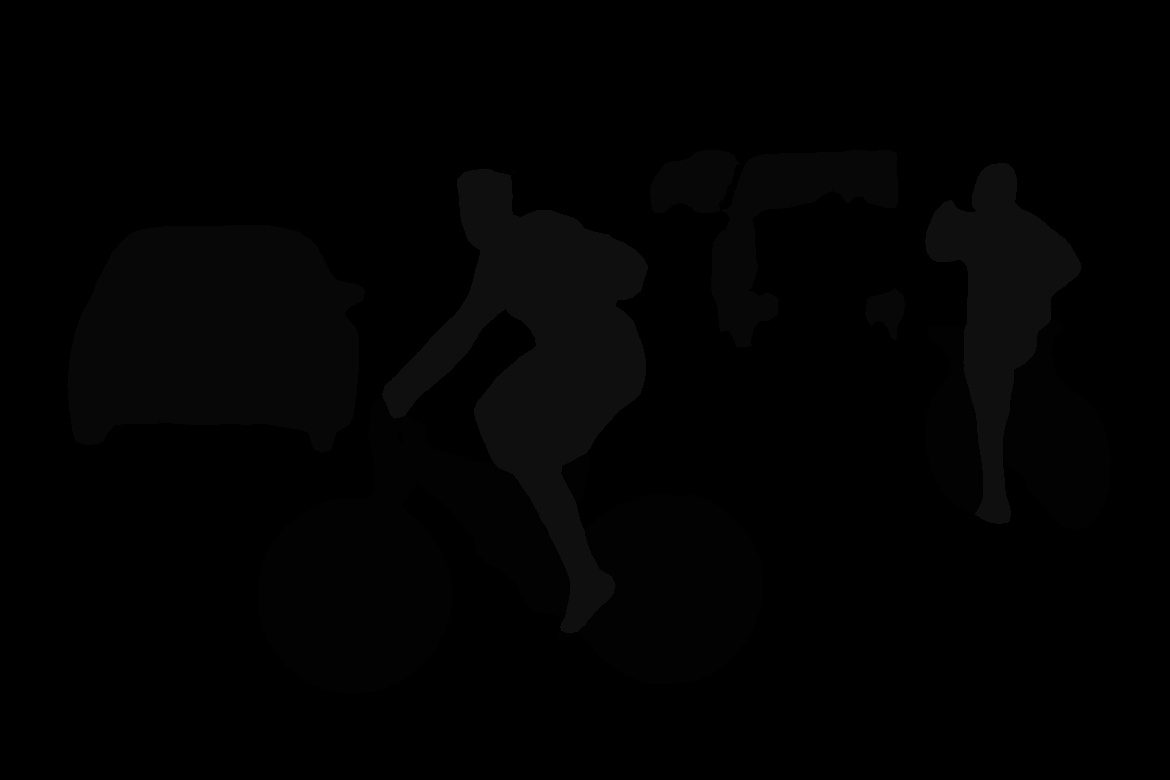

In [ ]:
#4(todo):출력된 이미지(Grayscale) 로컬영역에 저장하기(및 다시 불러와서 확인)

###################################### 코랩 전용
from google.colab.patches import cv2_imshow   #이 라인은 코랩에서만 사용
#####################################


img_cv = np.array(out)


########## 코랩 전용
cv2_imshow(img_cv)  #imshow의 파라미터는 ndarray

#cv.imshow(img_cv)
##########


cv.imwrite('test_gray_img.jpg', img_cv) # <____--_______________-여기에 저장경로 인가하면 됨. 
                                          #경로(문자열 객체)를 파라미터로 받아서 주면 될것.


test_img = cv.imread("test_gray_img.jpg",0)
#아래 링크에 cv.imread()의 flag값(본 코드에서 0)에 대한 정보.
#https://docs.opencv.org/3.4/d8/d6a/group__imgcodecs__flags.html#gga61d9b0126a3e57d9277ac48327799c80af660544735200cbe942eea09232eb822


#############################
cv2_imshow(test_img)
#cv2.imshow(test_img)
#############################

#Image.fromarray(output_predictions.byte().cpu().numpy())
#out.save("img_out_save.jpg",'JPEG')
#print('saving output img complete')
#4(todo) End



In [ ]:
type(test_img)

numpy.ndarray

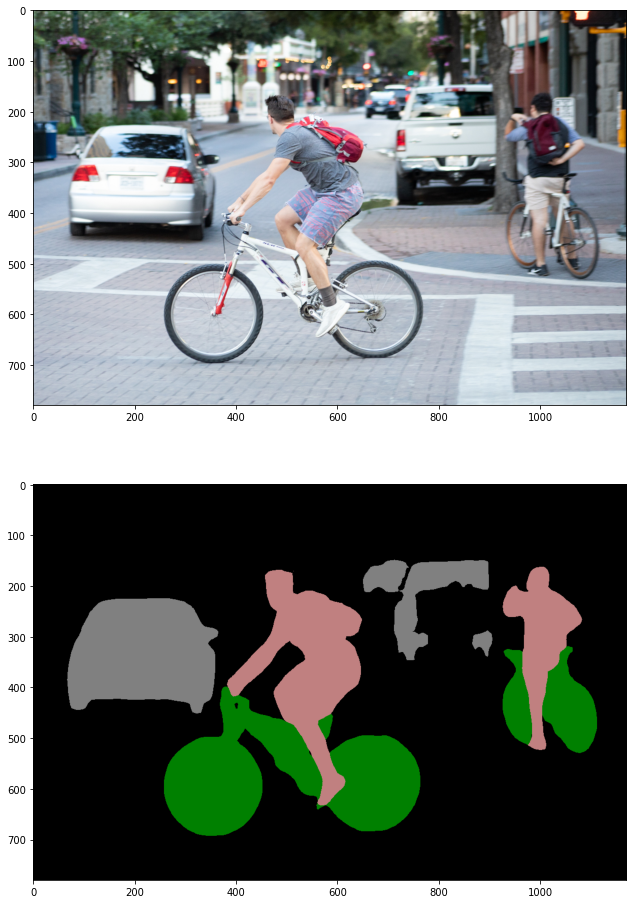

In [ ]:
#5(todo),2(todo) Class Map to Segmentation Map
#rgb이미지로 보여주기. 아마 파이썬으로 안해도 될 가능성 있으므로 사용은 불확실.
def seg_map(img, n_classes=21):
    rgb = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    for c in range(n_classes):
        idx = img == c

        rgb[idx] = COLORS[c]

    return rgb

out_seg = seg_map(out)


fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 16))
ax[0].imshow(img)
ax[1].imshow(out_seg)
